In [1]:
#!/bin/bash
!if [ ! -d course-v3 ]; then
!        pip install pillow==4.1.1 --upgrade
!        pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html --upgrade
!
!        sed -n -e '/^tmpfs \/dev\/shm tmpfs defaults,size=/!p' -e '$atmpfs \/dev\/shm tmpfs defaults,size=1g 0 0' -i /etc/fstab
!        mount -o remount /dev/shm

!        mkdir -p /root/.torch/models
!        mkdir -p /root/.fastai/data
!        ln -s /root/.torch/models /content
!        ln -s /root/.fastai/data /content
!        rm -rf /content/sample_data/
!        git clone https://github.com/fastai/course-v3
!fi

!pip install fastai --upgrade
!cd course-v3
!git pull

/bin/bash: -c: line 1: syntax error: unexpected end of file
    100% |████████████████████████████████| 5.7MB 6.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 578.2MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61980000 @  0x7fc8d4dfc2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
Cloning into 'course-v3'...
remote: Enumerating objects: 1991, done.
remote: Total 1991 (delta 0), reused 0 (delta 0), pack-reused 1991
Receiving objects: 100% (1991/1991), 39.34 MiB | 10.01 MiB/s, done.
Resolving deltas: 100% (1095/1095), done.
/bin/bash: -c: line 0: syntax er

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Creating a high quality images dataset from EyeEm 

The following tutorial walk you through how to create a high quality image dataset from EyeEm. 
**Note**: The steps have to be repeated for each class, as we basically need to get URLs for each class once at a time.

## Get a list of URLs

### Search and scroll

Go to [EyeEm](https://www.eyeem.com/) web site and search for the images you are interested in. Try to be as specific as possible so that the search result will match the class you're trying to build the dataset for, in any case you can alway manually delete files.

Keep scrolling down until you have a enough images as you will be able to download only the visible one. I don't know if there is a maximum to what EyeEm can return but I guess the limit is your browser memory.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press Ctrl+Shift+J in Windows/Linux and Cmd+Opt+J in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images in a **CSV** file. You can do this by running the following commands:



```
urls = Array.from(document.querySelectorAll('.sc-jWBwVP')).map(el=>el["children"][0].src);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

```

**Note** if you have an Ad blocker (I highly recommend you install one, check [uBlock Origin](https://en.wikipedia.org/wiki/UBlock_Origin)), you may need to disable it momentarly for the EyeEm website otherwise you won't be able to downand the CSV file with all image URLs.

### Create directory and upload urls file into your server

Upload the urls file to the root folder and create a unique folder for each class in the same root folder.

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from fastai import *
from fastai.vision import *

In [0]:
path = Path('/gdrive/My Drive/eyeem')

In [0]:
folders = ['airplane', 'motorcycle', 'ship']
for i in range(3):
    dest = path/folders[i]
    dest.mkdir(parents=True, exist_ok=True)

## Download images

For each class, download the images corresponding to the urls we got from EyeEm. I first tried using the fasai `download_images` helper function but it fails as the server response doesn't contains a `Content-Length` header. Instead we will just download the files manually:

In [7]:
import re
import requests
from tqdm import tqdm

# pattern to find the width in a url
width_pattern = r'w\/[0-9]+\n'
# pattern to find the filename in a url
fname_pattern = re.compile('-([0-9]+)\/')

files = ['urls_airplane.csv', 'urls_motorcycle.csv', 'urls_ship.csv']
pbar = tqdm(total=len(files))
for i in range(len(files)):
    folder = path/folders[i]
    urls = open((path/files[i]).as_posix())
    for url in urls:
        # clean the url to get a specific width
        url = re.sub(width_pattern, 'w/450', url)
        # send an HTTP request to get the image
        response = requests.get(url, stream=False)
        # get the image filename
        fname = fname_pattern.search(url).group(1) + '.jpg'
        # write the response content into a file
        with open((folder/fname).as_posix(), mode='wb') as localfile:
            localfile.write(response.content)
    pbar.update(1)

100%|██████████| 3/3 [06:10<00:00, 123.49s/it]

Cleanup the dataset by removing corrupted files if any using the fastai `verify_images` helper function

In [21]:
classes = ['airplane', 'motorcycle', 'ship']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

airplane


module 'PIL.Image' has no attribute 'register_decoder'
motorcycle


module 'PIL.Image' has no attribute 'register_decoder'
ship


## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes

['airplane', 'motorcycle', 'ship']

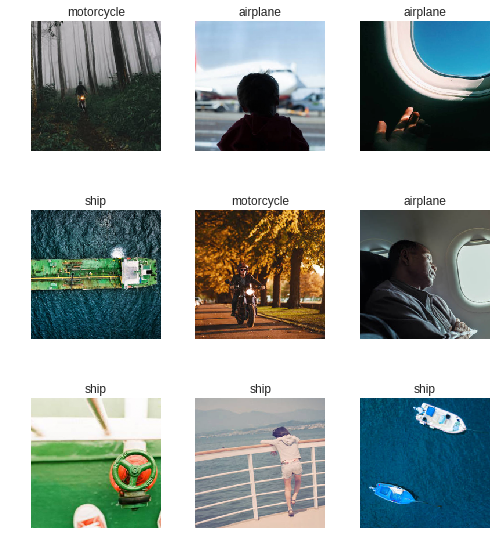

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['airplane', 'motorcycle', 'ship'], 3, 234, 66)

## Train model

In [12]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth

100%|██████████| 87306240/87306240 [00:01<00:00, 47449211.69it/s]

In [13]:
learn.fit_one_cycle(4)

Total time: 00:29
epoch  train_loss  valid_loss  error_rate
1      1.236282    0.919272    0.484848    (00:10)
2      0.970176    0.859724    0.363636    (00:06)
3      0.746483    0.618841    0.227273    (00:06)
4      0.605505    0.515494    0.181818    (00:06)



In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


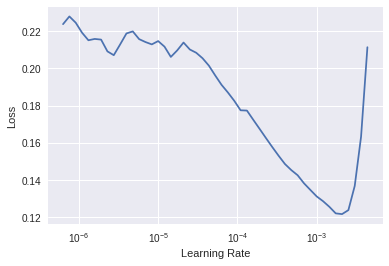

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(2, max_lr=slice(5e-5,1e-3))

Total time: 00:13
epoch  train_loss  valid_loss  error_rate
1      0.278513    0.444877    0.166667    (00:06)
2      0.197563    0.499108    0.181818    (00:07)



In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

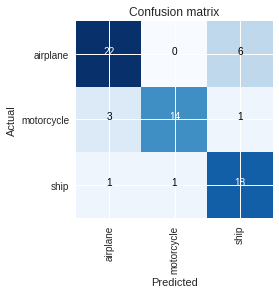

In [21]:
interp.plot_confusion_matrix()

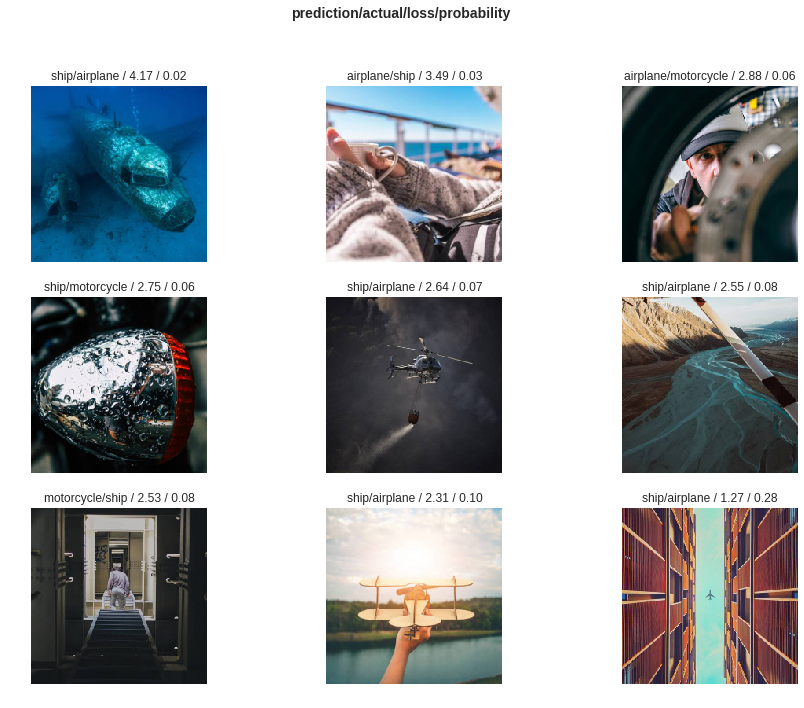

In [23]:
interp.plot_top_losses(9, figsize=(15,11))